In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
import random, math
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [2]:
import pickle
BASE_PATH = "/kaggle/input/cifar-10-and-cifar-10-c/cifar-10-python/cifar-10-batches-py"

def unpickle(file):
    with open(file ,'rb') as f:
        data_dict = pickle.load(f , encoding = 'bytes')
    return data_dict

In [3]:
test_data = []
test_label = []

test_path = os.path.join(BASE_PATH , 'test_batch')
test_batch = unpickle(test_path)
test_data.append(test_batch[b'data'])
test_label.extend(test_batch[b'labels'])

y_test = np.array(test_label)    

In [4]:
def cifar_flat_to_pil(img_flat):
    r = img_flat[0:1024].reshape(32,32)
    g = img_flat[1024:2048].reshape(32,32)
    b = img_flat[2048:3072].reshape(32,32)
    img = np.stack([r,g,b], axis=2).astype('uint8')
    pil_img = Image.fromarray(img).convert("RGB")
    return pil_img

# Converting a Fla

In [5]:
from PIL import Image
def cifar_dataset_to_pil(flat_images):
    pil_images = []
    for img_flat in flat_images:
        pil_img = cifar_flat_to_pil(img_flat)  # pass the array directly
        pil_images.append(pil_img)
    return pil_images

test_data_flat = np.vstack(test_data)   
test_images = cifar_dataset_to_pil(test_data_flat)

In [6]:
import torch

model_path = "/kaggle/input/custom-cnn/pytorch/default/1/best_model.pth"
state_dict = torch.load(model_path, map_location='cpu')

for k, v in state_dict.items():
    print(k, v.shape)


conv1.weight torch.Size([64, 3, 3, 3])
conv1.bias torch.Size([64])
conv2.weight torch.Size([128, 64, 3, 3])
conv2.bias torch.Size([128])
conv3.weight torch.Size([128, 128, 3, 3])
conv3.bias torch.Size([128])
conv4.weight torch.Size([256, 128, 3, 3])
conv4.bias torch.Size([256])
conv5.weight torch.Size([256, 256, 3, 3])
conv5.bias torch.Size([256])
conv6.weight torch.Size([256, 256, 3, 3])
conv6.bias torch.Size([256])
conv7.weight torch.Size([512, 256, 3, 3])
conv7.bias torch.Size([512])
conv8.weight torch.Size([512, 512, 3, 3])
conv8.bias torch.Size([512])
conv9.weight torch.Size([512, 512, 3, 3])
conv9.bias torch.Size([512])
bn1.weight torch.Size([64])
bn1.bias torch.Size([64])
bn1.running_mean torch.Size([64])
bn1.running_var torch.Size([64])
bn1.num_batches_tracked torch.Size([])
bn2.weight torch.Size([256])
bn2.bias torch.Size([256])
bn2.running_mean torch.Size([256])
bn2.running_var torch.Size([256])
bn2.num_batches_tracked torch.Size([])
bn3.weight torch.Size([512])
bn3.bias torc

In [7]:
class AdvancedCNNCheckpoint(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv3 = nn.Conv2d(128, 128, 3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)
        self.conv5 = nn.Conv2d(256, 256, 3, padding=1)
        self.conv6 = nn.Conv2d(256, 256, 3, padding=1)
        self.conv7 = nn.Conv2d(256, 512, 3, padding=1)
        self.conv8 = nn.Conv2d(512, 512, 3, padding=1)
        self.conv9 = nn.Conv2d(512, 512, 3, padding=1)

        # BatchNorm layers
        self.bn1 = nn.BatchNorm2d(64)
        self.bn2 = nn.BatchNorm2d(256)
        self.bn3 = nn.BatchNorm2d(512)

        # Pooling + dropout
        self.maxpool = nn.MaxPool2d(2,2)
        self.dropout = nn.Dropout2d(0.2)

        # Fully connected layers (matches checkpoint exactly)
        self.fc1 = nn.Linear(512*4*4, 8192)
        self.fc2 = nn.Linear(8192, 4096)
        self.fc3 = nn.Linear(4096, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.maxpool(x)

        x = self.relu(self.bn2(self.conv4(x)))
        x = self.relu(self.conv5(x))
        x = self.relu(self.conv6(x))
        x = self.maxpool(x)
        x = self.dropout(x)

        x = self.relu(self.bn3(self.conv7(x)))
        x = self.relu(self.conv8(x))
        x = self.relu(self.conv9(x))
        x = self.maxpool(x)
        x = self.dropout(x)

        x = torch.flatten(x, 1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = AdvancedCNNCheckpoint(num_classes=10)

state_dict = torch.load(model_path, map_location=device)
net.load_state_dict(state_dict)
net.to(device)
net.eval()

AdvancedCNNCheckpoint(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv7): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv8): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv9): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 

In [9]:
from torchvision import transforms

preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2470, 0.2435, 0.2616))
])

In [10]:
import numpy as np
import cv2

# ----------------------
# Gaussian Noise
# ----------------------
def add_gaussian_noise_np(img, sigma):
    noise = np.random.normal(0, sigma, img.shape)
    noisy_img = img + noise
    return np.clip(noisy_img, 0, 255).astype(np.uint8)

# ----------------------
# Poisson / ISO Noise
# ----------------------
def add_poisson_noise_np(img, scale=1.0):
    img_scaled = img * scale
    noisy_img = np.random.poisson(img_scaled).astype(np.float32) / scale
    return np.clip(noisy_img, 0, 255).astype(np.uint8)

# ----------------------
# Gaussian Blur
# ----------------------
def gaussian_blur_np(img, sigma):
    ksize = max(1, int(6*sigma+1) | 1)
    blurred = cv2.GaussianBlur(img, (ksize, ksize), sigmaX=sigma)
    return blurred

# ----------------------
# Motion Blur
# ----------------------
def motion_blur_np(img, length=5, angle=0):
    kernel = np.zeros((length, length))
    kernel[int((length-1)/2), :] = np.ones(length)
    M = cv2.getRotationMatrix2D((length/2-0.5, length/2-0.5), angle*180/np.pi, 1)
    kernel = cv2.warpAffine(kernel, M, (length, length))
    kernel = kernel / kernel.sum() if kernel.sum()!=0 else kernel
    blurred = cv2.filter2D(img, -1, kernel)
    return blurred

# ----------------------
# JPEG Compression
# ----------------------
def jpeg_compression_np(img, quality=50):
    # Convert RGB→BGR for OpenCV
    _, encimg = cv2.imencode('.jpg', img, [int(cv2.IMWRITE_JPEG_QUALITY), quality])
    decimg = cv2.imdecode(encimg, 1)
    # Convert back to RGB
    decimg = cv2.cvtColor(decimg, cv2.COLOR_BGR2RGB)
    return decimg

# ----------------------
# Brightness / Contrast
# ----------------------
def adjust_brightness_contrast_np(img, brightness=1.0, contrast=1.0):
    img = img.astype(np.float32)
    img = img * contrast + (brightness-1)*128
    return np.clip(img, 0, 255).astype(np.uint8)

# ----------------------
# Color Shift (Hue/Saturation)
# ----------------------
def color_shift_np(img, hue_shift_deg=0, sat_shift=0.0):
    hsv = cv2.cvtColor(img.astype(np.uint8), cv2.COLOR_RGB2HSV).astype(np.float32)
    hsv[...,0] = (hsv[...,0] + hue_shift_deg) % 180
    hsv[...,1] = np.clip(hsv[...,1] + sat_shift*255, 0, 255)
    return cv2.cvtColor(hsv.astype(np.uint8), cv2.COLOR_HSV2RGB)

In [11]:
corruption_appliers = {
    "gaussian_noise": lambda im, lvl: add_gaussian_noise_np(im, sigma=lvl),
    "poisson_noise": lambda im, lvl: add_poisson_noise_np(im, scale=lvl),
    "gaussian_blur": lambda im, lvl: gaussian_blur_np(im, sigma=lvl),
    "motion_blur": lambda im, lvl: motion_blur_np(im, length=int(lvl), angle=random.uniform(0, 2*math.pi)),
    "jpeg_compression": lambda im, lvl: cv2.cvtColor(jpeg_compression_np(cv2.cvtColor(im, cv2.COLOR_RGB2BGR), quality=int(lvl)), cv2.COLOR_BGR2RGB),
    "brightness": lambda im, lvl: adjust_brightness_contrast_np(im, brightness=float(lvl), contrast=1.0),
    "contrast": lambda im, lvl: adjust_brightness_contrast_np(im, brightness=1.0, contrast=float(lvl)),
    "color_shift": lambda im, lvl: color_shift_np(im, hue_shift_deg=int(lvl[0]), sat_shift=float(lvl[1]))
}

corruption_params = {
    "gaussian_noise": [5, 20, 40],        
    "poisson_noise": [0.25, 1.0, 4.0],
    "gaussian_blur": [1, 3, 6],
    "motion_blur": [3, 10, 20],
    "jpeg_compression": [90, 50, 20],
    "brightness": [0.5, 1.0, 1.5],
    "contrast": [0.5, 1.0, 1.5],
    "color_shift": [(5,0.05), (20,0.2), (40,0.4)]
}

In [19]:
from sklearn.metrics import f1_score, confusion_matrix
import numpy as np

def evaluate_model_on_corruption(model, images_pil, labels, corruption_name, levels, num_classes, batch_size=128):
    model.eval()
    results = []
    applier = corruption_appliers[corruption_name]

    for lvl in levels:
        all_preds = []
        all_labels = []
        all_confs = []

        for bstart in range(0, len(images_pil), batch_size):
            batch_imgs = images_pil[bstart:bstart+batch_size]
            batch_labels = labels[bstart:bstart+batch_size]
            batch_tensor = []

            for img in batch_imgs:
                np_img = np.array(img)
                corrupted_np = applier(np_img, lvl)
                corrupted_pil = Image.fromarray(corrupted_np)
                batch_tensor.append(preprocess(corrupted_pil))  # your preprocessing pipeline

            batch_tensor = torch.stack(batch_tensor).to(device)
            batch_labels_tensor = torch.tensor(batch_labels, device=device)

            with torch.no_grad():
                outputs = model(batch_tensor)
                probs = torch.softmax(outputs, dim=1)
                preds = probs.argmax(dim=1)
                confs = probs.max(1).values

                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(batch_labels_tensor.cpu().numpy())
                all_confs.extend(confs.cpu().numpy())

        # Metrics
        all_preds_np = np.array(all_preds)
        all_labels_np = np.array(all_labels)

        overall_acc = np.mean(all_preds_np == all_labels_np)
        per_class_f1 = f1_score(all_labels_np, all_preds_np, average=None)
        
        # Per-class accuracy
        per_class_acc = []
        for c in range(num_classes):
            idx = all_labels_np == c
            if np.sum(idx) > 0:
                acc_c = np.mean(all_preds_np[idx] == all_labels_np[idx])
            else:
                acc_c = np.nan
            per_class_acc.append(acc_c)

        # Confusion matrix
        cm = confusion_matrix(all_labels_np, all_preds_np, labels=range(num_classes))

        print(f"{corruption_name} level {lvl} -> acc {overall_acc:.4f}")
        results.append({
            "level": lvl,
            "accuracy": overall_acc,
            "per_class_f1": per_class_f1,
            "per_class_acc": per_class_acc,
            "confusion_matrix": cm,
            "preds": all_preds_np,
            "labels": all_labels_np
        })

    return results


In [21]:
import warnings
warnings.filterwarnings('ignore')

for corr_name, levels in corruption_params.items():
    print(f"\n==================== Evaluating Corruption: {corr_name.upper()} ====================")
    
    # Evaluate model and print full metrics per level
    res = evaluate_model_on_corruption(
        model=net,
        images_pil=test_images,
        labels=y_test,
        corruption_name=corr_name,
        levels=levels,
        num_classes=10  # CIFAR-10
    )
    
    # Store results in a structured dictionary
    robustness_results[corr_name] = res

    # Optional: quick summary after each corruption
    accs = [r['accuracy'] for r in res]
    print(f"Summary - Accuracies for {corr_name}: {['{:.4f}'.format(a) for a in accs]}")


==================== Evaluating Corruption: GAUSSIAN_NOISE ====================
gaussian_noise level 5 -> acc 0.8909
gaussian_noise level 20 -> acc 0.5348
gaussian_noise level 40 -> acc 0.2120
Summary - Accuracies for gaussian_noise: ['0.8909', '0.5348', '0.2120']

==================== Evaluating Corruption: POISSON_NOISE ====================
poisson_noise level 0.25 -> acc 0.5134
poisson_noise level 1.0 -> acc 0.7703
poisson_noise level 4.0 -> acc 0.8831
Summary - Accuracies for poisson_noise: ['0.5134', '0.7703', '0.8831']

==================== Evaluating Corruption: GAUSSIAN_BLUR ====================
gaussian_blur level 1 -> acc 0.5768
gaussian_blur level 3 -> acc 0.1599
gaussian_blur level 6 -> acc 0.1597
Summary - Accuracies for gaussian_blur: ['0.5768', '0.1599', '0.1597']

==================== Evaluating Corruption: MOTION_BLUR ====================
motion_blur level 3 -> acc 0.8058
motion_blur level 10 -> acc 0.2707
motion_blur level 20 -> acc 0.1825
Summary - Accuracies for mo

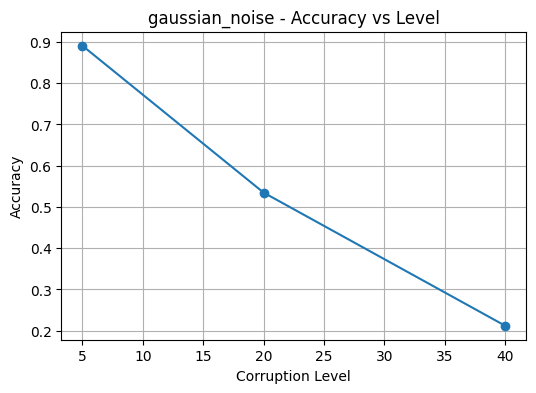

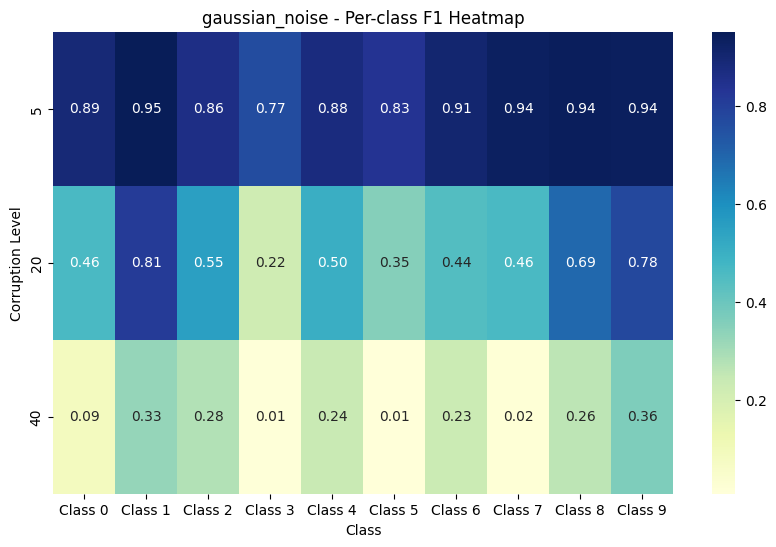

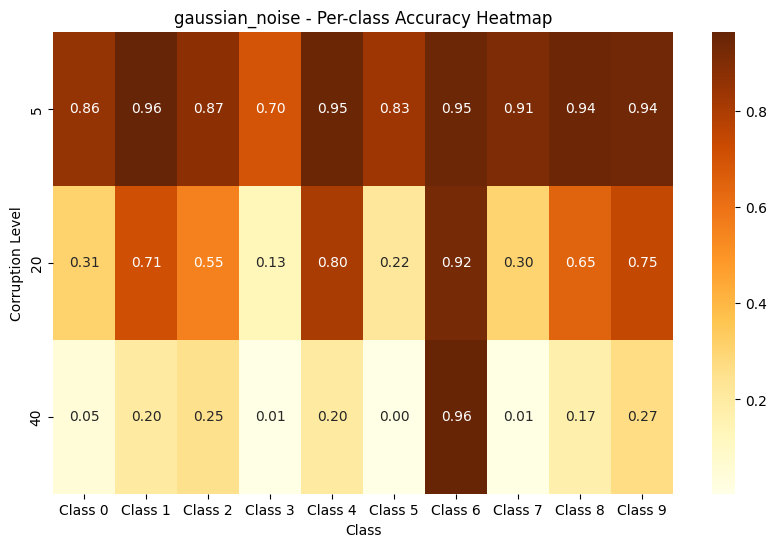

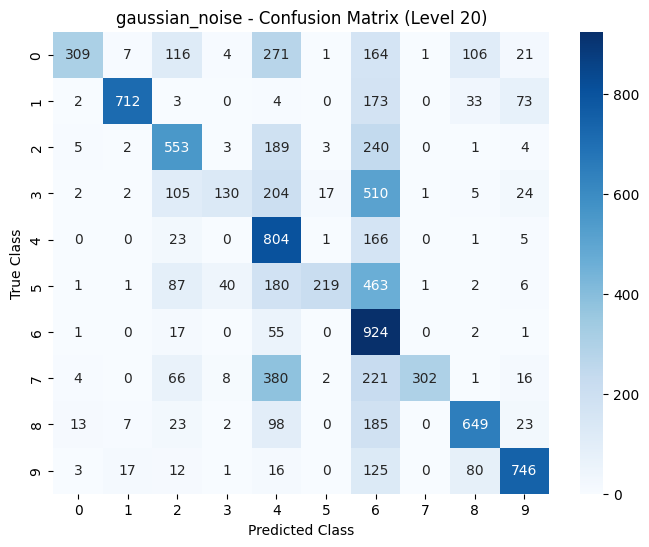

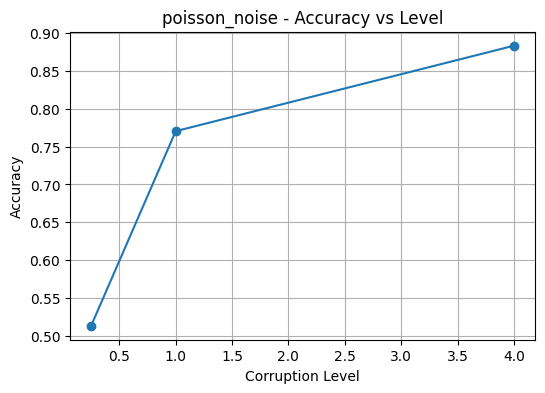

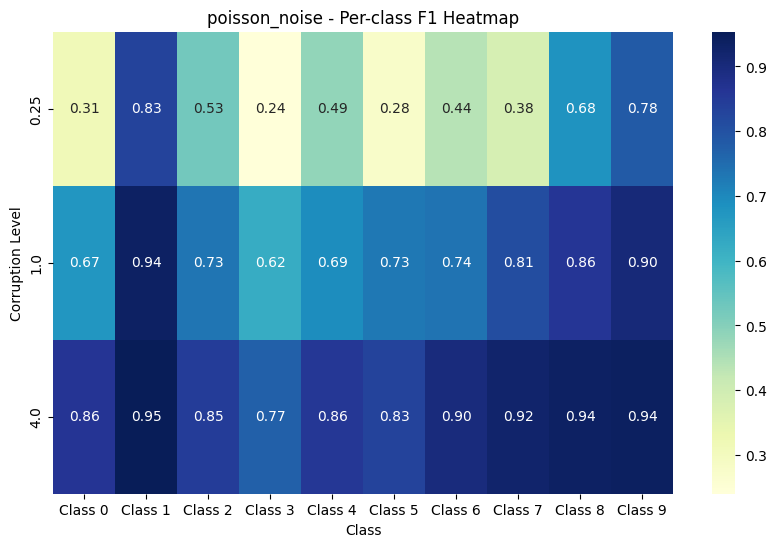

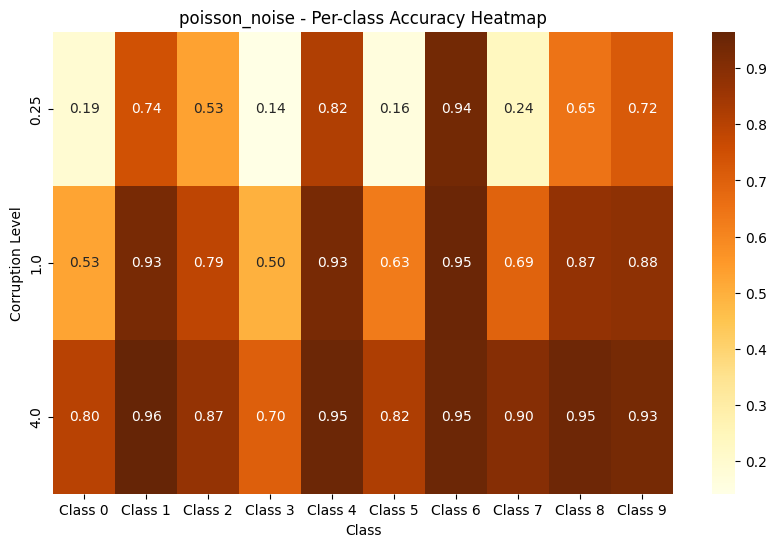

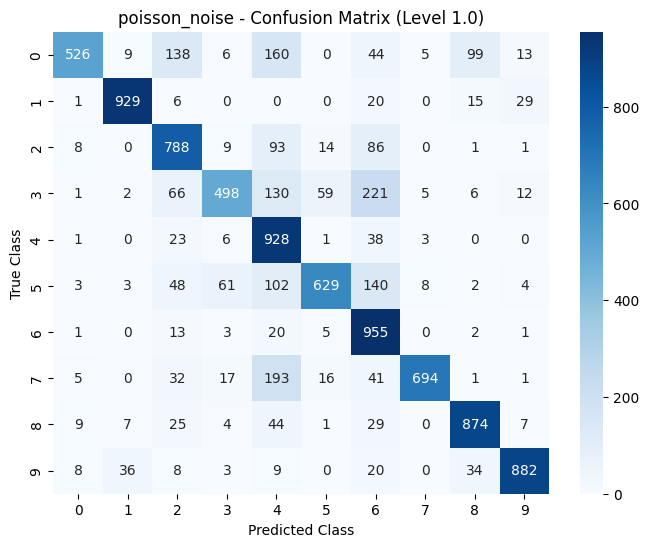

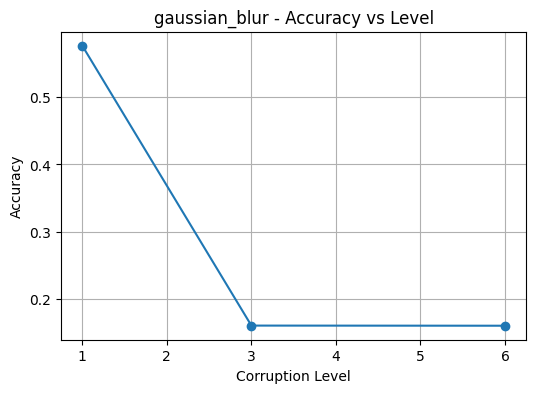

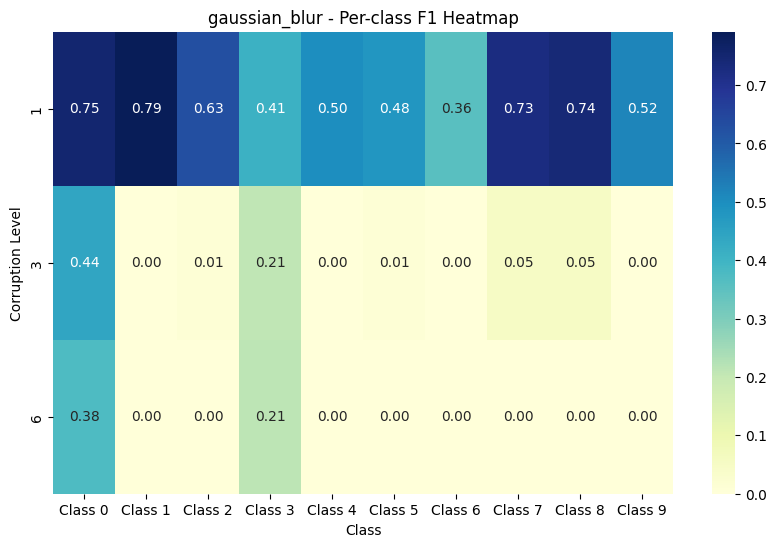

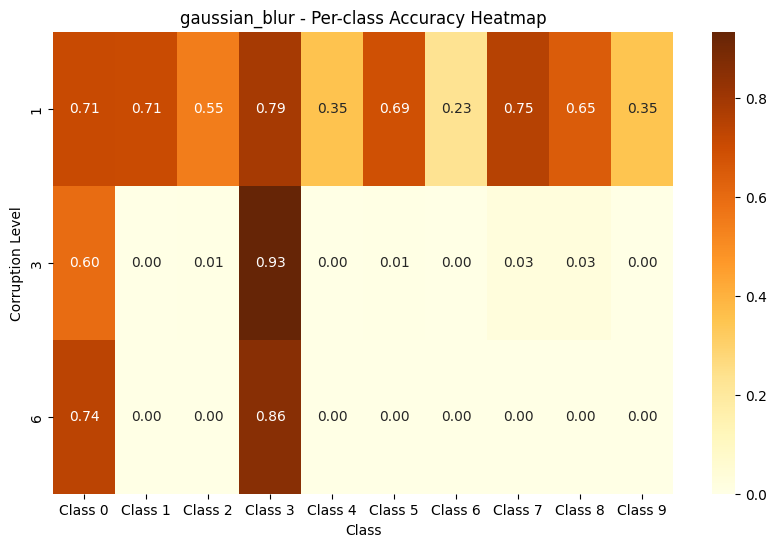

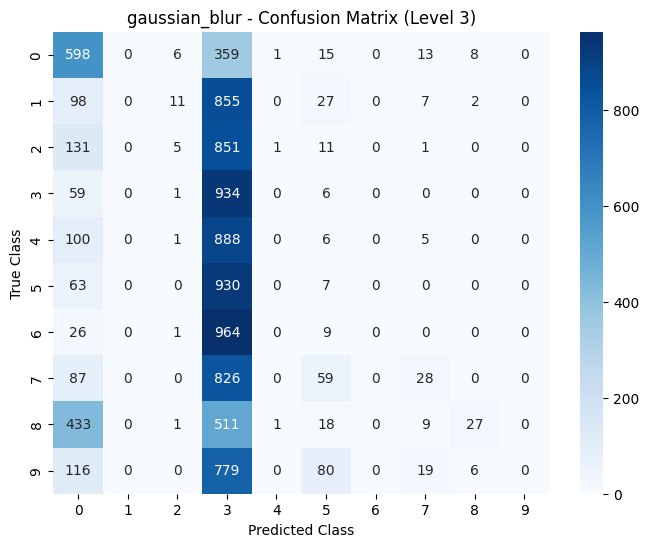

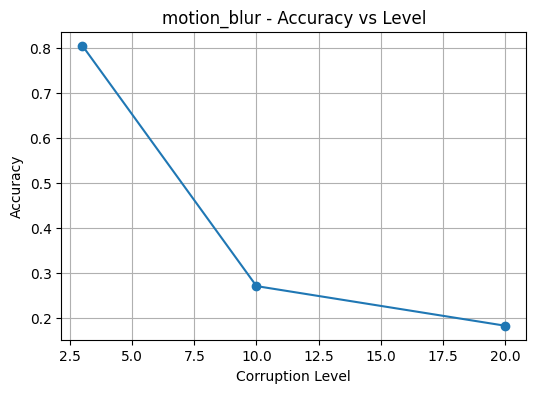

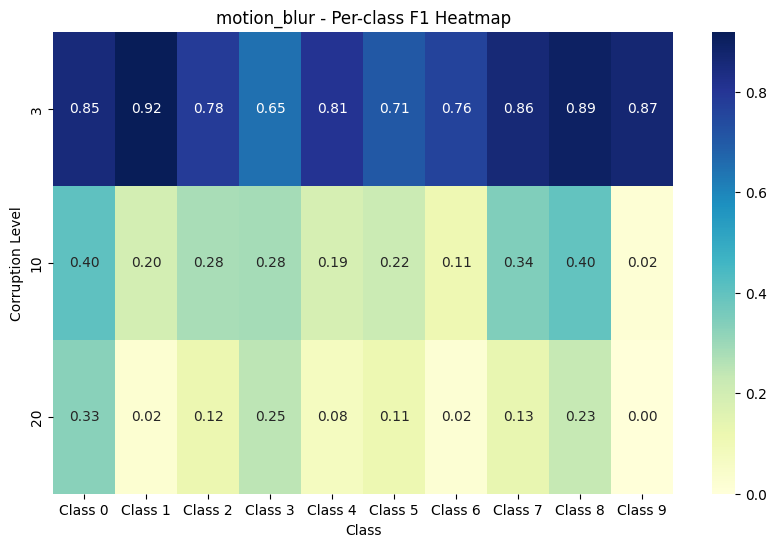

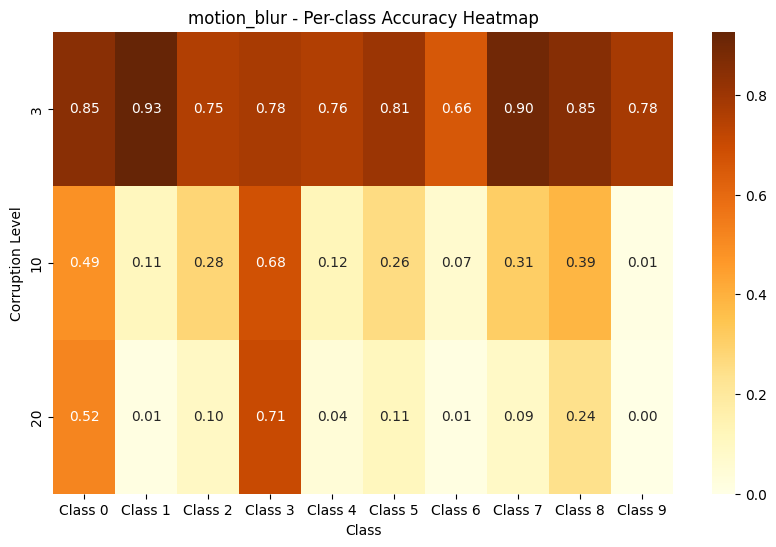

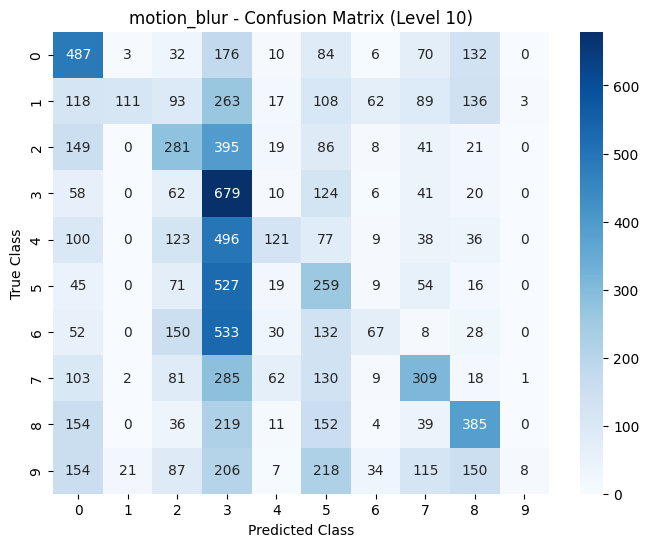

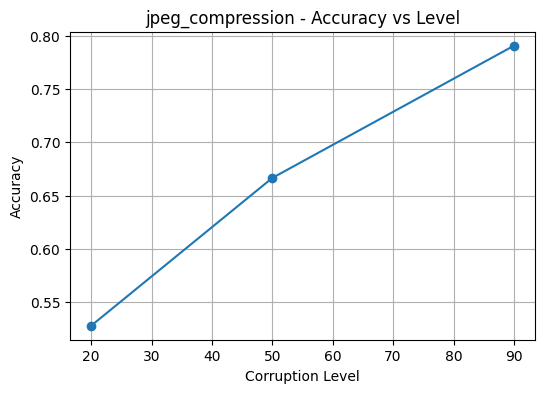

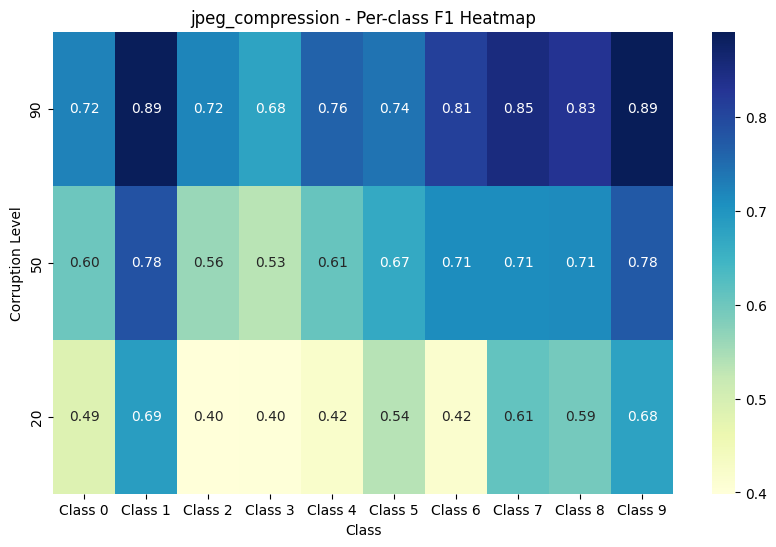

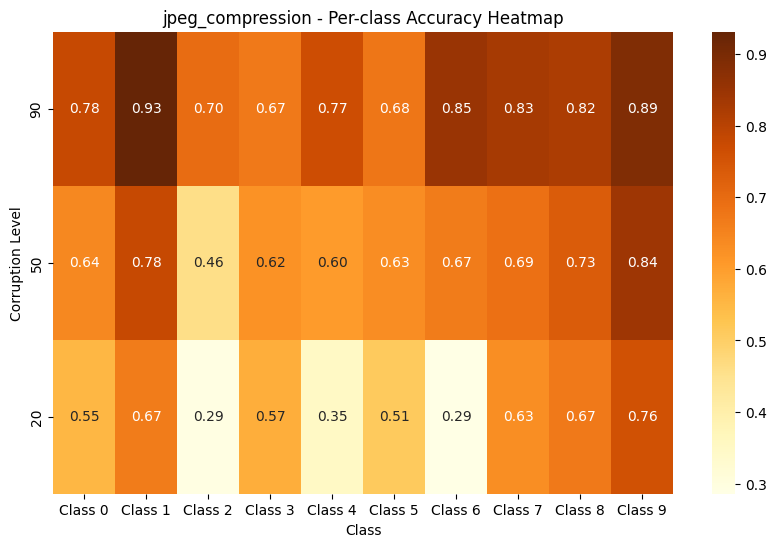

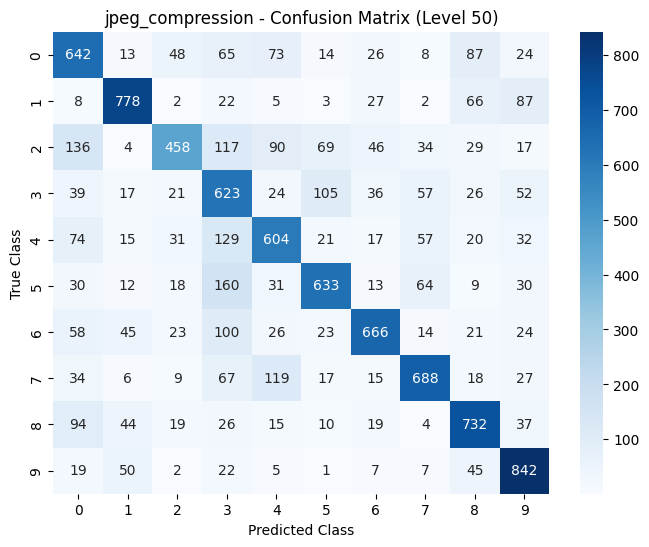

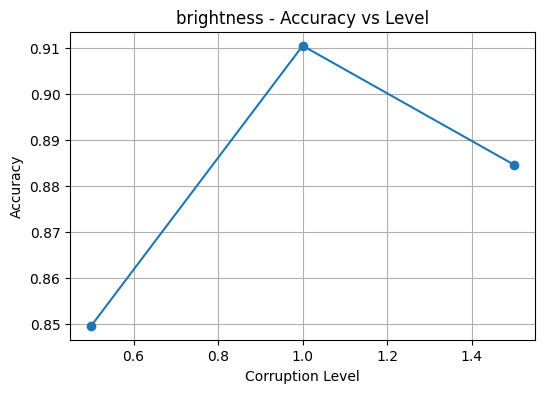

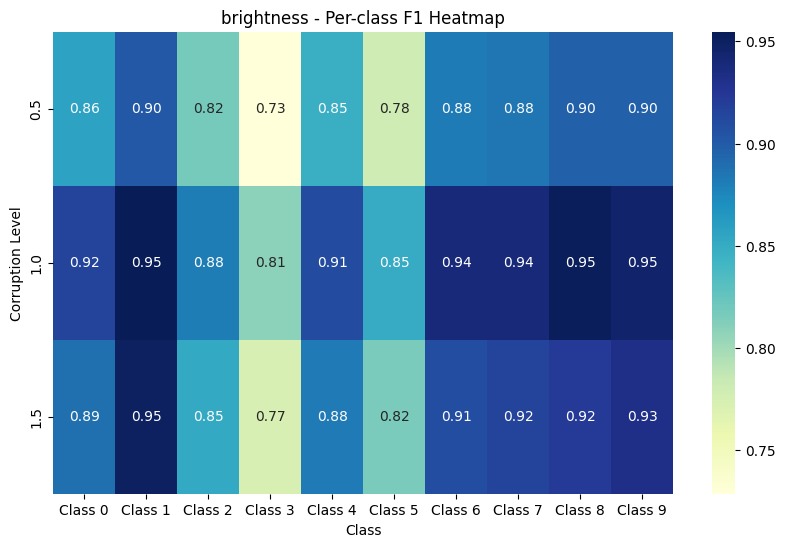

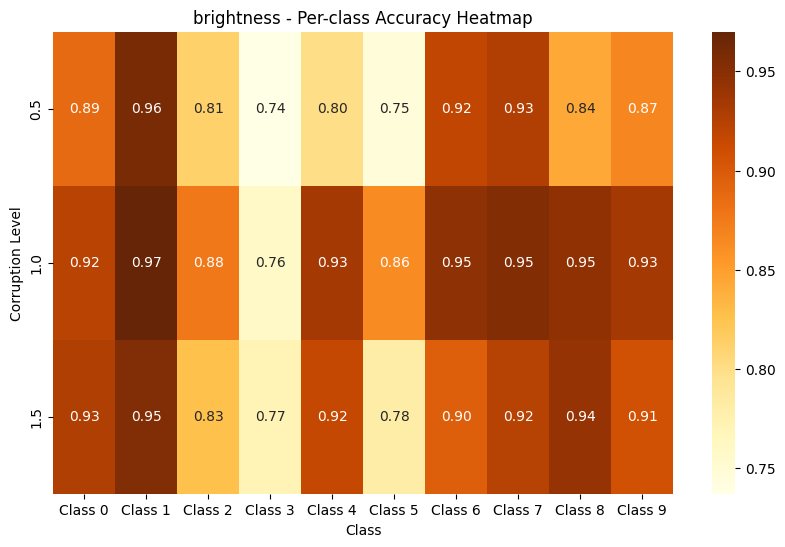

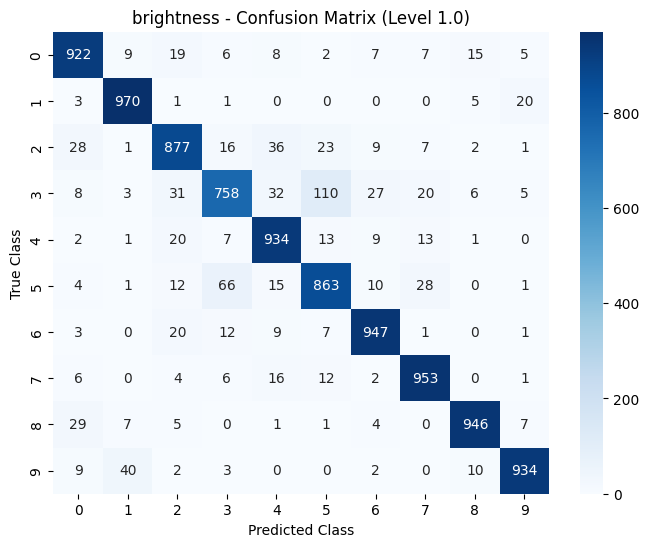

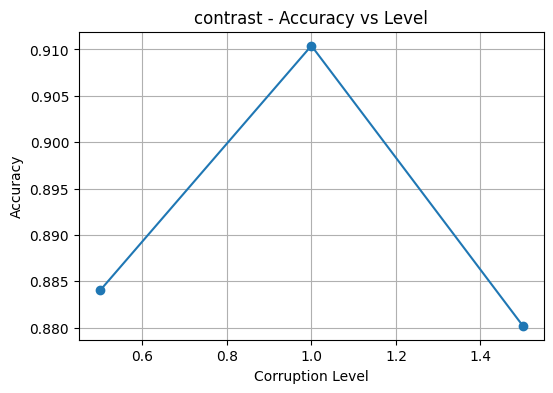

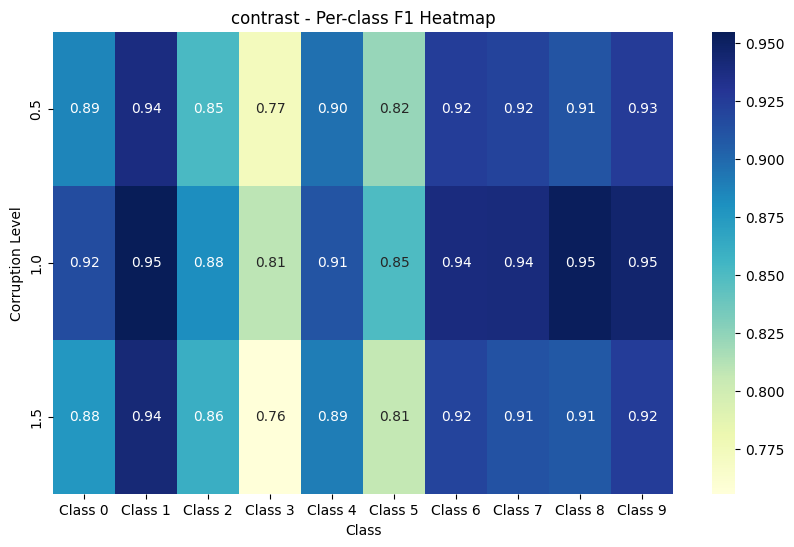

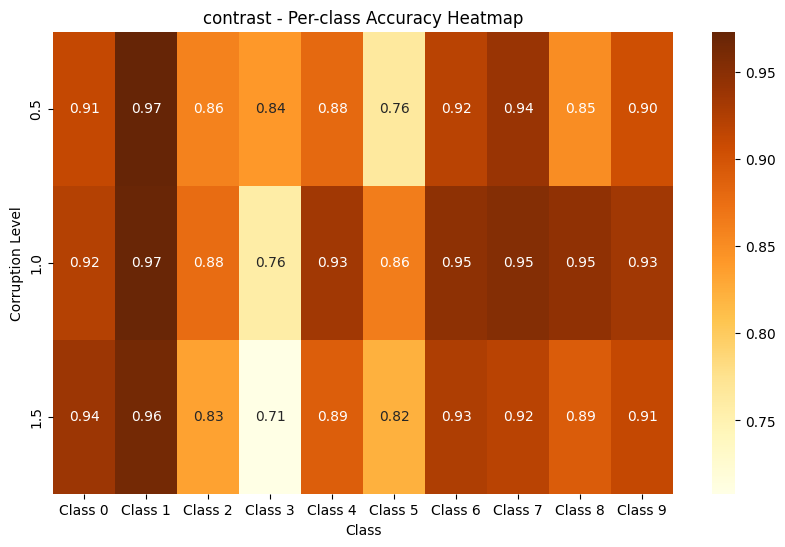

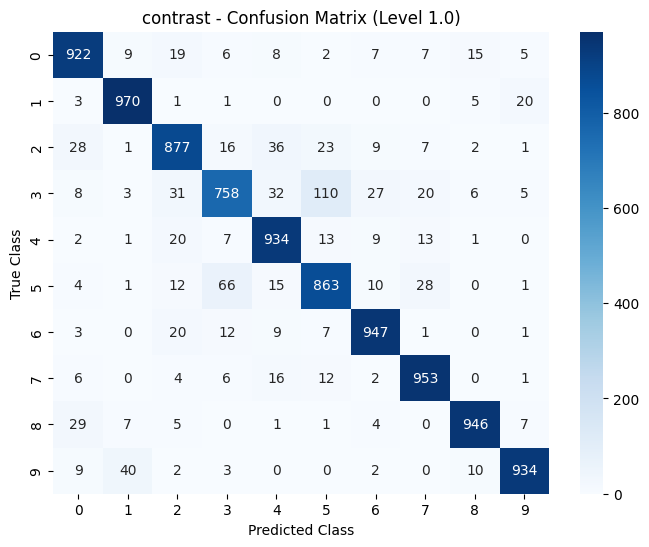

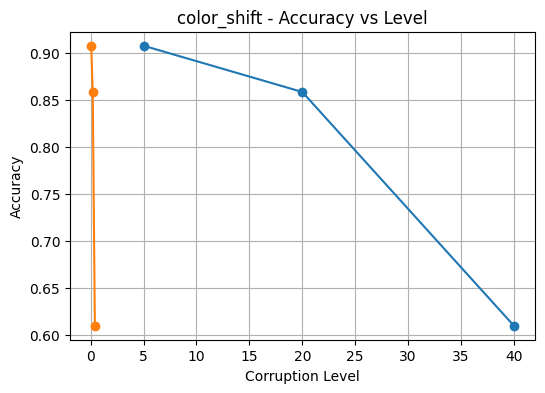

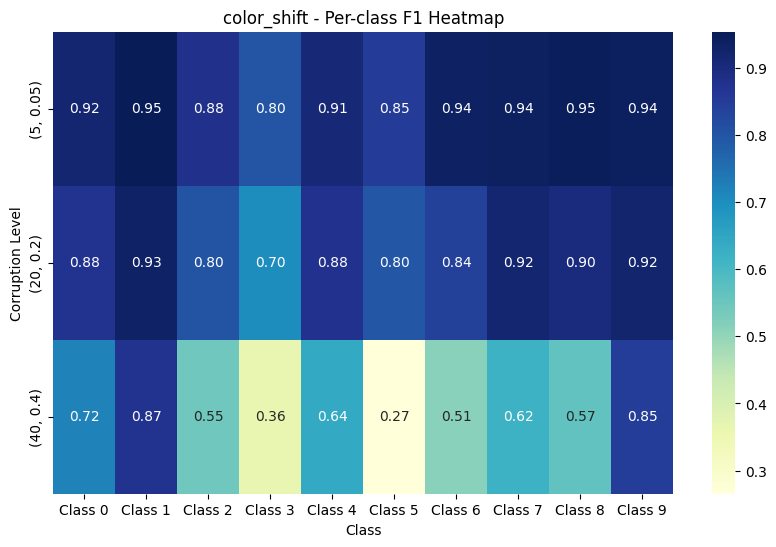

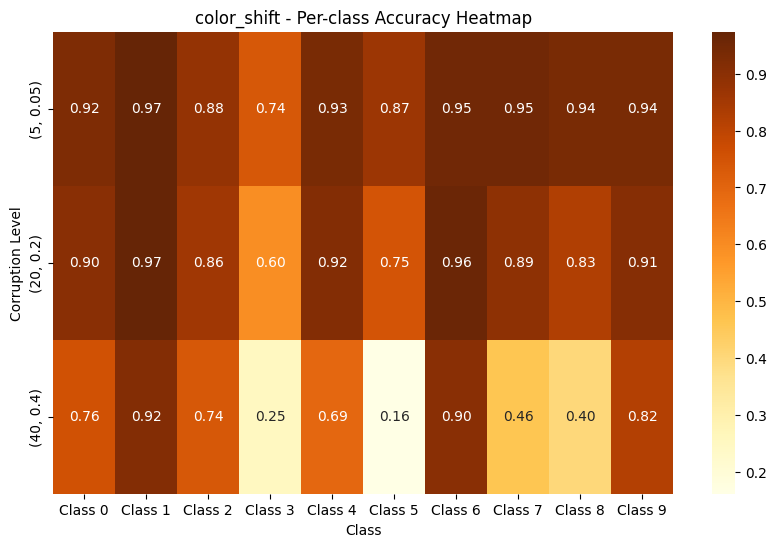

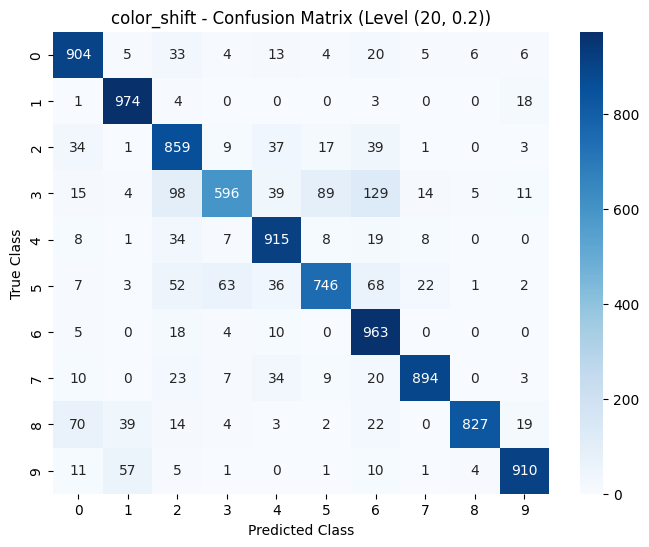

In [24]:
import seaborn as sns
def visualize_robustness(robustness_results, corruption_names=None):
    if corruption_names is None:
        corruption_names = robustness_results.keys()
    
    for corr_name in corruption_names:
        res_list = robustness_results[corr_name]
        levels = [r['level'] for r in res_list]
        accs = [r['accuracy'] for r in res_list]
        per_class_f1 = np.array([r['per_class_f1'] for r in res_list])
        per_class_acc = np.array([r['per_class_acc'] for r in res_list])
        

        plt.figure(figsize=(6,4))
        plt.plot(levels, accs, marker='o', label='Accuracy')
        plt.title(f"{corr_name} - Accuracy vs Level")
        plt.xlabel("Corruption Level")
        plt.ylabel("Accuracy")
        plt.grid(True)
        plt.show()
        
        plt.figure(figsize=(10,6))
        sns.heatmap(per_class_f1, annot=True, fmt=".2f", cmap="YlGnBu", 
                    xticklabels=[f"Class {i}" for i in range(per_class_f1.shape[1])],
                    yticklabels=levels)
        plt.title(f"{corr_name} - Per-class F1 Heatmap")
        plt.xlabel("Class")
        plt.ylabel("Corruption Level")
        plt.show()
        

        plt.figure(figsize=(10,6))
        sns.heatmap(per_class_acc, annot=True, fmt=".2f", cmap="YlOrBr", 
                    xticklabels=[f"Class {i}" for i in range(per_class_acc.shape[1])],
                    yticklabels=levels)
        plt.title(f"{corr_name} - Per-class Accuracy Heatmap")
        plt.xlabel("Class")
        plt.ylabel("Corruption Level")
        plt.show()
        
        medium_idx = len(levels)//2
        cm = res_list[medium_idx]['confusion_matrix']
        plt.figure(figsize=(8,6))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
        plt.title(f"{corr_name} - Confusion Matrix (Level {levels[medium_idx]})")
        plt.xlabel("Predicted Class")
        plt.ylabel("True Class")
        plt.show()


visualize_robustness(robustness_results)


I will be applying Guassian Noise and Blur and see what happens at differnet levels of my Convolutional Layer

In [25]:
target_layers = {
    "conv1": net.conv1,
    "conv2": net.conv2,
    "conv4": net.conv4,
    "conv7": net.conv7
}

activations = {}

def get_activation(name):
    def hook(model, input, output):
        activations[name] = output.detach()
    return hook

for name, layer in target_layers.items():
    layer.register_forward_hook(get_activation(name))

img = test_images[0]  
np_img = np.array(img)

In [ ]:
import matplotlib.pyplot as plt

def show_feature_maps(feature_tensor, title="", num_maps=6):
    fmap = feature_tensor.squeeze(0)  # remove batch dim
    plt.figure(figsize=(15, 3))
    for i in range(min(num_maps, fmap.shape[0])):
        plt.subplot(1, num_maps, i+1)
        plt.imshow(fmap[i].cpu(), cmap='rgb')
        plt.axis('off')
    plt.suptitle(title, fontsize=14)
    plt.show()


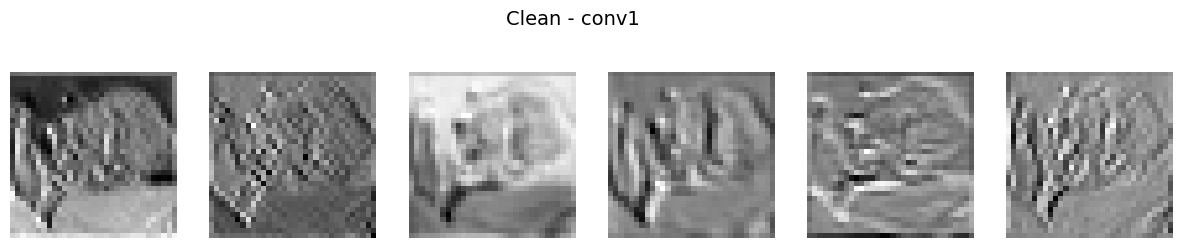

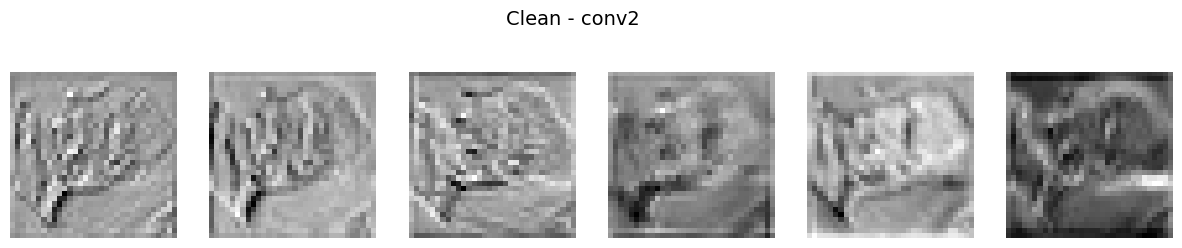

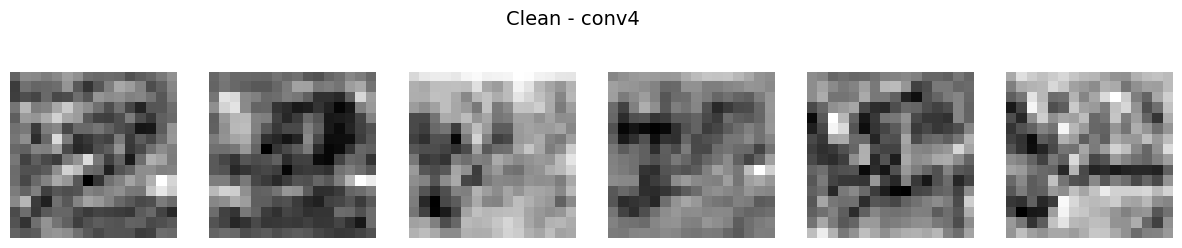

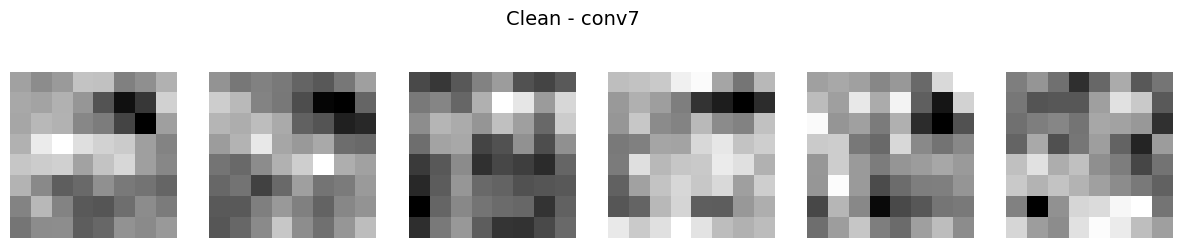

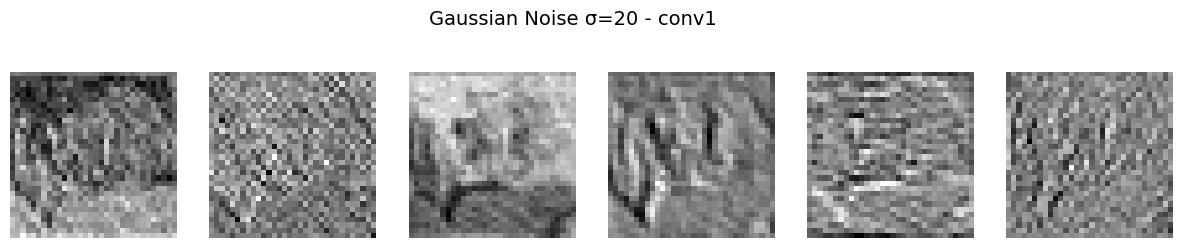

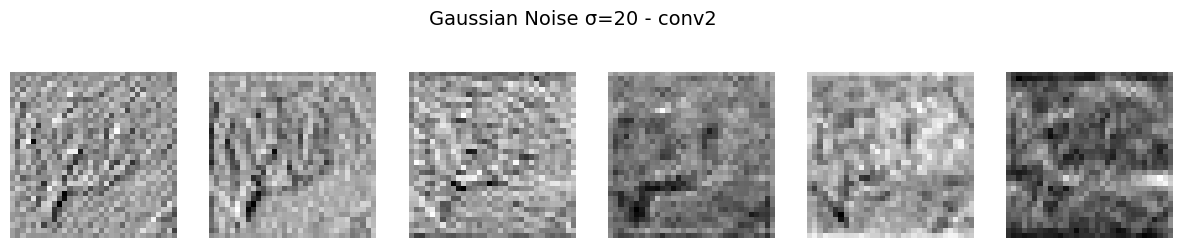

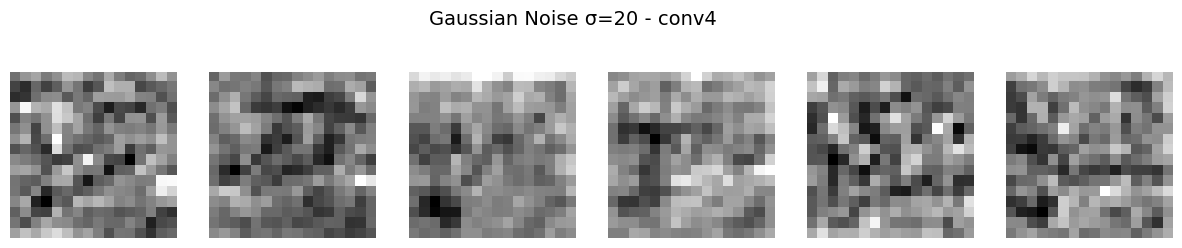

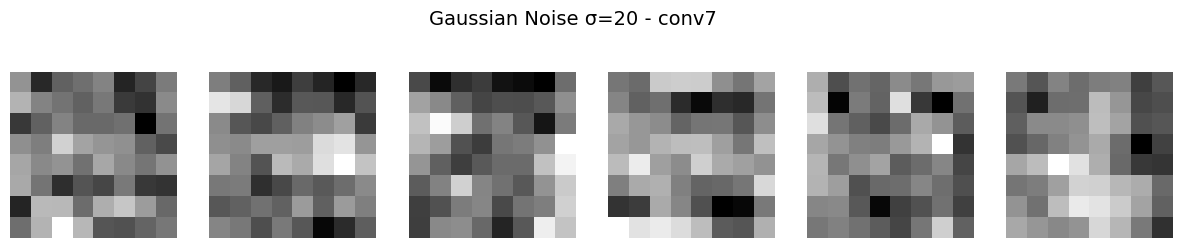

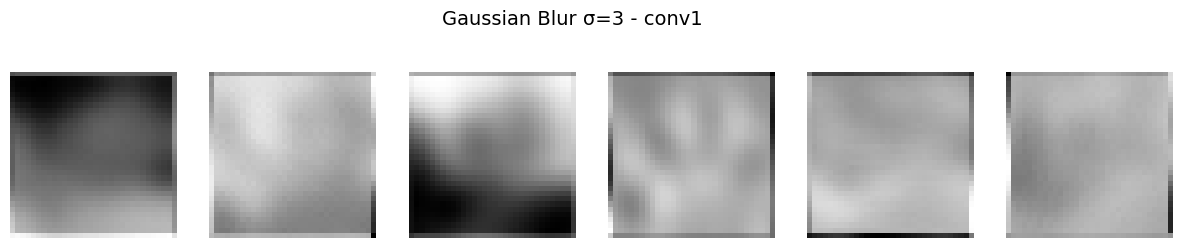

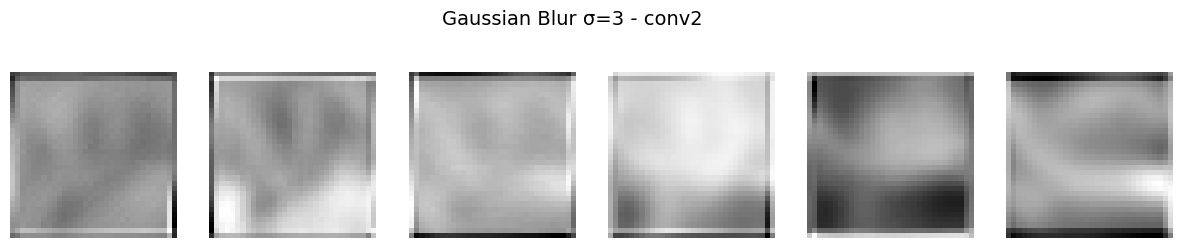

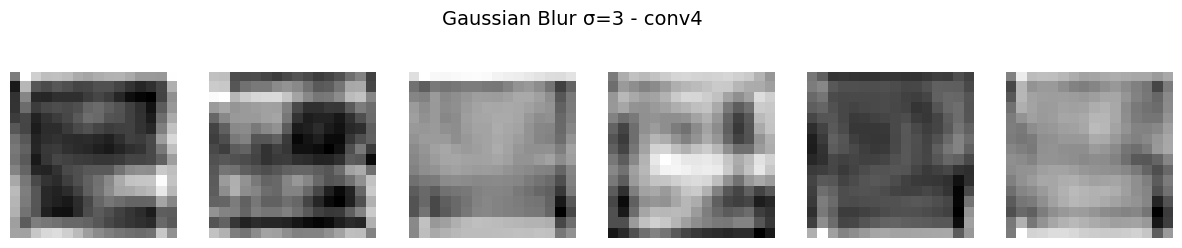

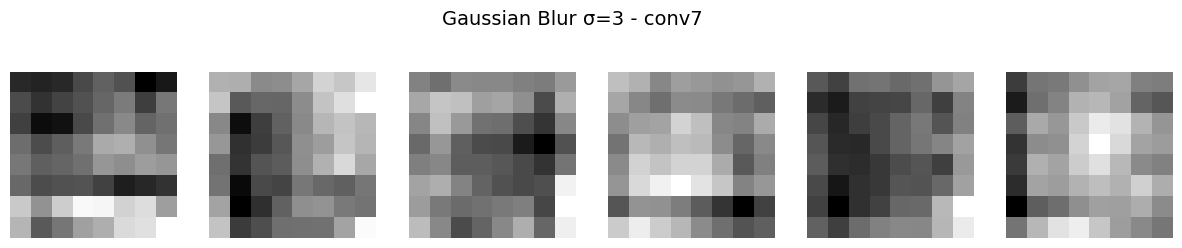

In [28]:
# Clean image
input_tensor = preprocess(img).unsqueeze(0).to(device)
with torch.no_grad():
    _ = net(input_tensor)
for lname in target_layers.keys():
    show_feature_maps(activations[lname], title=f"Clean - {lname}")

# Gaussian noise
input_tensor = preprocess(Image.fromarray(add_gaussian_noise_np(np_img, sigma=10))).unsqueeze(0).to(device)
with torch.no_grad():
    _ = net(input_tensor)
for lname in target_layers.keys():
    show_feature_maps(activations[lname], title=f"Gaussian Noise σ=20 - {lname}")

# Gaussian blur
input_tensor = preprocess(Image.fromarray(gaussian_blur_np(np_img, sigma=3))).unsqueeze(0).to(device)
with torch.no_grad():
    _ = net(input_tensor)
for lname in target_layers.keys():
    show_feature_maps(activations[lname], title=f"Gaussian Blur σ=3 - {lname}")
